<a href="https://colab.research.google.com/github/tinywizzard/HAAI_Codes/blob/main/FineTuningAndTrainingFromScratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import all necessary libraries

In [1]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 14.6 MB/s eta 0:00:00


In [2]:
import torch
import torch.utils.data
from torchvision import transforms
from torchvision.datasets import CIFAR100
import numpy as np
from torchvision.models import resnet18, ResNet18_Weights
from tqdm import tqdm
from torchmetrics import Accuracy
import matplotlib.pyplot as plt
import seaborn as sns

## Setup the Data Class (CIFAR100)
Always create classes for major modules This will make your projects modular, allowing you to switch different, in this case, datasets and test your model. Out of all the advantages of this coding habit, one advantage of creating multiple objects of the data class is that it allows you to perform ensemble learning.

In [3]:
class DataModule():
    def __init__(self, batch_size):
        super().__init__()
        self.batch_size = batch_size
        # We define some augmentations that we would like to apply during training
        self.train_transform = transforms.Compose([
            transforms.Resize(256),             # CIFAR100 image size is 32x32, so resizing to 256x256 to get close to training data
            transforms.RandomCrop(224, 4),      # Random crop for augmentation
            transforms.RandomHorizontalFlip(),  # Random horizontal flip for augmentation
            transforms.ToTensor(),              # Converting image to tensor
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # Subtracting mean then divind by std deviation; three values for RGB
        ])
        # During validation we need to only normalize and resize
        self.val_transform = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])

    # This function sets up our datasets
    # which includes downloading and applying the augmentations
    def prepare_data(self):
        self.train_set = CIFAR100(root='./data', train=True, download=True, transform=self.train_transform)
        self.val_set = CIFAR100(root='./data', train=False, download=True, transform=self.val_transform)

    # This function sets up the data loaders
    def setup(self):
        self.train_data_loader = torch.utils.data.DataLoader(self.train_set, batch_size=self.batch_size, shuffle=True)
        self.val_data_loader = torch.utils.data.DataLoader(self.val_set, batch_size=self.batch_size, shuffle=False)

    # This is simply a getter function for the training data loader
    def train_dataloader(self):
        return self.train_data_loader

    # This is simply a getter function for the validation data loader
    def val_dataloader(self):
        return self.val_data_loader

## Setup the Model Class
Here we will define the model, forward pass and its behaviour during each trainig/validation iteration.

In [9]:
class DLModel(torch.nn.Module):
    def __init__(self, num_classes, pretrained=True, num_unfreeze_layers=0):
        super().__init__()
        # If you want to use the imagenet pretrained weights
        if pretrained:
            self.backbone = resnet18(weights=ResNet18_Weights.DEFAULT) # Import pretrained model
            # We freeze the entire model
            self.backbone.requires_grad_(False)
            # If you want to unfreeze some of the layers then
            if num_unfreeze_layers > 0:
                # First find number of layers
                num_layers = 0
                for name, module in self.named_modules():
                    if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear) or isinstance(module, torch.nn.BatchNorm2d):
                        num_layers += 1
                # Following which unfreeze the last set of layers
                start_unfreezing_counter, counter = num_layers - num_unfreeze_layers, 0
                for name, module in self.named_modules():
                    if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear) or isinstance(module, torch.nn.BatchNorm2d):
                        counter += 1
                    if counter >= start_unfreezing_counter:
                        module.requires_grad_(True)
        # Otherwise just initialize the network from scratch
        else:
            self.backbone = resnet18(weights=None)
            self.backbone.requires_grad_(True)
        # The resnet model comes with a 1000 neuron final layer for the imagenet dataset
        self.backbone.fc = torch.nn.Sequential(
            torch.nn.Linear(512, num_classes)
        )

        # Define the objective function
        self.criterion = torch.nn.CrossEntropyLoss()
        # Define the metrics
        self.train_acc1, self.val_acc1 = Accuracy(task="multiclass", num_classes=num_classes), Accuracy(task="multiclass", num_classes=num_classes)
        self.train_acc5, self.val_acc5 = Accuracy(task="multiclass", num_classes=num_classes, top_k=5), Accuracy(task="multiclass", num_classes=num_classes, top_k=5)

    # This function sets up the optimizer and scheduler that we'll use
    def configure_optimizers(self, lr, momentum, max_epochs):
        self.optimizer = torch.optim.SGD(self.parameters(), lr=lr, momentum=momentum)
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=max_epochs)

    # This defines the behaviour of our model during the forward pass
    # Based on the defined behaviour, PyTorch sets up the backward pass
    def forward(self, x):
        out = self.backbone(x)
        return out

    # This function describes model behaviour per iteration during training
    def training_step(self, x, y):
        self.optimizer.zero_grad()          # Clear all the gradients
        preds = self.forward(x)             # Forward pass
        self.train_acc1.update(preds, y)    # Update accuracy metrics - top 1
        self.train_acc5.update(preds, y)    # Update accuracy metrics - top 5
        loss = self.criterion(preds, y)     # Calculate loss
        loss.backward()                     # Backward pass - calculates gradients
        self.optimizer.step()               # Update weights

        return loss.item()

    # Once the epoch is complete, we call call this function for inspecting the model's performance
    def on_training_epoch_end(self, loss, epoch):
        acc1, acc5 = self.train_acc1.compute().item(), self.train_acc5.compute().item()
        print(f"Epoch No: {epoch+1}\nTraining Loss: {loss}\nTraining Accuracy: {acc1} (Top-1)\t {acc5} (Top-5)")
        return acc1, acc5

    # This function describes model behaviour per iteration during validation
    def validation_step(self, x, y):
        preds = self.forward(x)
        self.val_acc1.update(preds, y)
        self.val_acc5.update(preds, y)
        loss = self.criterion(preds, y)
        return loss.item()

    # Once the validation iterations are complete, we can call this function for inspecting the model's performance
    def on_validation_epoch_end(self, loss, epoch):
        acc1, acc5 = self.val_acc1.compute().item(), self.val_acc5.compute().item()
        print(f"Validation Loss: {loss}\nValidation Accuracy: {acc1} (Top-1)\t {acc5} (Top-5)")
        return acc1, acc5

    # This function resets the metrics so that new results can be calculated for the next epoch
    def reset_metrics(self):
        self.train_acc1.reset(), self.train_acc5.reset()
        self.val_acc1.reset(), self.val_acc5.reset()

## Putting it all together
We first define some static and global variables

In [5]:
# First define some static variables
num_classes = 100
num_epochs = 10
batch_size = 128
# Fine-tuning and training from scratch requires different sets of learning rates
lr_finetune, lr_scratch = 0.001, 0.1
momentum = 0.9
device = torch.device("cuda")

# Define the data
data_module = DataModule(batch_size=batch_size)
data_module.prepare_data()
data_module.setup()
train_loader, val_loader = data_module.train_dataloader(), data_module.val_dataloader()

100%|██████████| 169001437/169001437 [00:04<00:00, 42033866.45it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


## Shallow Fine-tuning
We first take a look at shallow fine-tuning (training only the final layer and keeping the remaining model frozen)

In [10]:
# This variable will be used to save the per-epoch validation accuracy
shallow_finetuning_val_acc = []
# This variable will be used to save the per-epoch training loss
shallow_finetuning_train_loss = []

# Define the model
model = DLModel(num_classes=num_classes, pretrained=True, num_unfreeze_layers=0).to(device)
model.configure_optimizers(lr=lr_finetune, momentum=momentum, max_epochs=num_epochs)

# Start the training loop
for epoch in range(num_epochs):
    # This is the training cycle
    model.train()
    avg_loss = 0
    for x, y in tqdm(train_loader, total=len(train_loader)):
        x, y = x.to(device), y.to(device)
        avg_loss += model.training_step(x, y)
    avg_loss /= len(train_loader)
    shallow_finetuning_train_loss.append(avg_loss)
    acc1, acc5 = model.on_training_epoch_end(avg_loss, epoch)

    # This is the validation cycle
    model.eval()
    avg_loss = 0
    # Iterate over each batch and get the predictions
    for x, y in tqdm(val_loader, total=len(val_loader)):
        x, y = x.to(device), y.to(device)
        avg_loss += model.validation_step(x, y)
    avg_loss /= len(val_loader)
    acc1, acc5 = model.on_validation_epoch_end(avg_loss, epoch)
    shallow_finetuning_val_acc.append(acc1)

    # Finally reset the metrics before going on to the next batch
    model.reset_metrics()

100%|██████████| 391/391 [02:32<00:00,  2.56it/s]


Epoch No: 1
Training Loss: 4.151250597156222
Training Accuracy: 0.12734000384807587 (Top-1)	 0.32113999128341675 (Top-5)


100%|██████████| 79/79 [00:26<00:00,  3.04it/s]


Validation Loss: 3.5632176519949224
Validation Accuracy: 0.2770000100135803 (Top-1)	 0.5828999876976013 (Top-5)


100%|██████████| 391/391 [02:45<00:00,  2.36it/s]


Epoch No: 2
Training Loss: 3.2706777000671154
Training Accuracy: 0.33851999044418335 (Top-1)	 0.6505399942398071 (Top-5)


100%|██████████| 79/79 [00:28<00:00,  2.77it/s]


Validation Loss: 2.8925405876545964
Validation Accuracy: 0.39570000767707825 (Top-1)	 0.7199000120162964 (Top-5)


100%|██████████| 391/391 [02:46<00:00,  2.35it/s]


Epoch No: 3
Training Loss: 2.7786152125014674
Training Accuracy: 0.4191400110721588 (Top-1)	 0.7376199960708618 (Top-5)


100%|██████████| 79/79 [00:28<00:00,  2.81it/s]


Validation Loss: 2.5092715040037903
Validation Accuracy: 0.45489999651908875 (Top-1)	 0.7627999782562256 (Top-5)


100%|██████████| 391/391 [02:46<00:00,  2.35it/s]


Epoch No: 4
Training Loss: 2.487268586902667
Training Accuracy: 0.45857998728752136 (Top-1)	 0.7683600187301636 (Top-5)


100%|██████████| 79/79 [00:28<00:00,  2.79it/s]


Validation Loss: 2.2953147284592252
Validation Accuracy: 0.4812999963760376 (Top-1)	 0.7813000082969666 (Top-5)


100%|██████████| 391/391 [02:46<00:00,  2.35it/s]


Epoch No: 5
Training Loss: 2.2967980908006047
Training Accuracy: 0.4796999990940094 (Top-1)	 0.785260021686554 (Top-5)


100%|██████████| 79/79 [00:28<00:00,  2.75it/s]


Validation Loss: 2.12808817398699
Validation Accuracy: 0.49900001287460327 (Top-1)	 0.8009999990463257 (Top-5)


100%|██████████| 391/391 [02:38<00:00,  2.47it/s]


Epoch No: 6
Training Loss: 2.168552442584806
Training Accuracy: 0.4968000054359436 (Top-1)	 0.7981399893760681 (Top-5)


100%|██████████| 79/79 [00:30<00:00,  2.62it/s]


Validation Loss: 2.0214678365972976
Validation Accuracy: 0.5116000175476074 (Top-1)	 0.8066999912261963 (Top-5)


100%|██████████| 391/391 [02:39<00:00,  2.45it/s]


Epoch No: 7
Training Loss: 2.0723995357523184
Training Accuracy: 0.5069400072097778 (Top-1)	 0.8058599829673767 (Top-5)


100%|██████████| 79/79 [00:26<00:00,  2.95it/s]


Validation Loss: 1.9599343508104734
Validation Accuracy: 0.5178999900817871 (Top-1)	 0.8083999752998352 (Top-5)


100%|██████████| 391/391 [02:54<00:00,  2.24it/s]


Epoch No: 8
Training Loss: 2.0028858294572367
Training Accuracy: 0.5141400098800659 (Top-1)	 0.8110799789428711 (Top-5)


100%|██████████| 79/79 [00:26<00:00,  3.00it/s]


Validation Loss: 1.8851795694496059
Validation Accuracy: 0.5291000008583069 (Top-1)	 0.8170999884605408 (Top-5)


100%|██████████| 391/391 [02:41<00:00,  2.42it/s]


Epoch No: 9
Training Loss: 1.9366822913479622
Training Accuracy: 0.5238400101661682 (Top-1)	 0.8176199793815613 (Top-5)


100%|██████████| 79/79 [00:28<00:00,  2.81it/s]


Validation Loss: 1.8360501588145388
Validation Accuracy: 0.5339999794960022 (Top-1)	 0.8234000205993652 (Top-5)


100%|██████████| 391/391 [02:41<00:00,  2.42it/s]


Epoch No: 10
Training Loss: 1.8876103553015862
Training Accuracy: 0.5307599902153015 (Top-1)	 0.8225799798965454 (Top-5)


100%|██████████| 79/79 [00:30<00:00,  2.62it/s]

Validation Loss: 1.8046965297264388
Validation Accuracy: 0.5393999814987183 (Top-1)	 0.8234999775886536 (Top-5)


## Deep Fine-tuning
We now take a look at deep fine-tuning (training some of the final layers while keeping the remaining layers frozen)

In [11]:
# This variable will be used to save the per-epoch validation accuracy
deep_finetuning_val_acc = []
# This variable will be used to save the per-epoch training loss
deep_finetuning_train_loss = []

# Define the model
model = DLModel(num_classes=num_classes, pretrained=True, num_unfreeze_layers=31).to(device)
model.configure_optimizers(lr=lr_finetune, momentum=momentum, max_epochs=num_epochs)

# Start the training loop
for epoch in range(num_epochs):
    # This is the training cycle
    model.train()
    avg_loss = 0
    for x, y in tqdm(train_loader, total=len(train_loader)):
        x, y = x.to(device), y.to(device)
        avg_loss += model.training_step(x, y)
    avg_loss /= len(train_loader)
    deep_finetuning_train_loss.append(avg_loss)
    acc1, acc5 = model.on_training_epoch_end(avg_loss, epoch)

    # This is the validation cycle
    model.eval()
    avg_loss = 0
    # Iterate over each batch and get the predictions
    for x, y in tqdm(val_loader, total=len(val_loader)):
        x, y = x.to(device), y.to(device)
        avg_loss += model.validation_step(x, y)
    avg_loss /= len(val_loader)
    acc1, acc5 = model.on_validation_epoch_end(avg_loss, epoch)
    deep_finetuning_val_acc.append(acc1)

    # Finally reset the metrics before going on to the next batch
    model.reset_metrics()

100%|██████████| 391/391 [04:05<00:00,  1.59it/s]


Epoch No: 1
Training Loss: 3.349419207829039
Training Accuracy: 0.28929999470710754 (Top-1)	 0.5512400269508362 (Top-5)


100%|██████████| 79/79 [00:28<00:00,  2.73it/s]


Validation Loss: 2.1429621826244305
Validation Accuracy: 0.5062000155448914 (Top-1)	 0.819100022315979 (Top-5)


100%|██████████| 391/391 [03:38<00:00,  1.79it/s]


Epoch No: 2
Training Loss: 1.7809134185161737
Training Accuracy: 0.5786200165748596 (Top-1)	 0.8658599853515625 (Top-5)


100%|██████████| 79/79 [00:29<00:00,  2.72it/s]


Validation Loss: 1.4111811405495753
Validation Accuracy: 0.6399999856948853 (Top-1)	 0.9082000255584717 (Top-5)


100%|██████████| 391/391 [03:38<00:00,  1.79it/s]


Epoch No: 3
Training Loss: 1.3182783677145038
Training Accuracy: 0.6620000004768372 (Top-1)	 0.9174200296401978 (Top-5)


100%|██████████| 79/79 [00:28<00:00,  2.72it/s]


Validation Loss: 1.1624525144130369
Validation Accuracy: 0.683899998664856 (Top-1)	 0.9266999959945679 (Top-5)


100%|██████████| 391/391 [03:38<00:00,  1.79it/s]


Epoch No: 4
Training Loss: 1.0976577349331067
Training Accuracy: 0.7063400149345398 (Top-1)	 0.9381999969482422 (Top-5)


100%|██████████| 79/79 [00:28<00:00,  2.73it/s]


Validation Loss: 1.0176657679714733
Validation Accuracy: 0.7171000242233276 (Top-1)	 0.9397000074386597 (Top-5)


100%|██████████| 391/391 [03:37<00:00,  1.80it/s]


Epoch No: 5
Training Loss: 0.9626756667176171
Training Accuracy: 0.7360799908638 (Top-1)	 0.9502999782562256 (Top-5)


100%|██████████| 79/79 [00:29<00:00,  2.72it/s]


Validation Loss: 0.9316395702241342
Validation Accuracy: 0.7354999780654907 (Top-1)	 0.9484000205993652 (Top-5)


100%|██████████| 391/391 [03:37<00:00,  1.79it/s]


Epoch No: 6
Training Loss: 0.8617179562978428
Training Accuracy: 0.7592599987983704 (Top-1)	 0.9585400223731995 (Top-5)


100%|██████████| 79/79 [00:28<00:00,  2.72it/s]


Validation Loss: 0.8703393792804284
Validation Accuracy: 0.7486000061035156 (Top-1)	 0.9526000022888184 (Top-5)


100%|██████████| 391/391 [03:37<00:00,  1.79it/s]


Epoch No: 7
Training Loss: 0.7851917749780524
Training Accuracy: 0.7791600227355957 (Top-1)	 0.9652400016784668 (Top-5)


100%|██████████| 79/79 [00:29<00:00,  2.71it/s]


Validation Loss: 0.8299988198883926
Validation Accuracy: 0.7605000138282776 (Top-1)	 0.9570000171661377 (Top-5)


100%|██████████| 391/391 [03:37<00:00,  1.80it/s]


Epoch No: 8
Training Loss: 0.7229907492847394
Training Accuracy: 0.796180009841919 (Top-1)	 0.9688599705696106 (Top-5)


100%|██████████| 79/79 [00:29<00:00,  2.72it/s]


Validation Loss: 0.8037765908844864
Validation Accuracy: 0.7628999948501587 (Top-1)	 0.957099974155426 (Top-5)


100%|██████████| 391/391 [03:37<00:00,  1.80it/s]


Epoch No: 9
Training Loss: 0.6708522969499573
Training Accuracy: 0.8081600069999695 (Top-1)	 0.9731400012969971 (Top-5)


100%|██████████| 79/79 [00:28<00:00,  2.73it/s]


Validation Loss: 0.7711197175557101
Validation Accuracy: 0.7730000019073486 (Top-1)	 0.9595000147819519 (Top-5)


100%|██████████| 391/391 [03:37<00:00,  1.80it/s]


Epoch No: 10
Training Loss: 0.6220719866130663
Training Accuracy: 0.8217999935150146 (Top-1)	 0.976140022277832 (Top-5)


100%|██████████| 79/79 [00:28<00:00,  2.74it/s]

Validation Loss: 0.7536500473565693
Validation Accuracy: 0.7781000137329102 (Top-1)	 0.960099995136261 (Top-5)


## Training from Scratch
Finally, we train the ResNet18 model from scratch on CIFAR100 dataset

In [12]:
# This variable will be used to save the per-epoch validation accuracy
scratch_val_acc = []
# This variable will be used to save the per-epoch training loss
scratch_train_loss = []

# Define the model
model = DLModel(num_classes=num_classes, pretrained=False, num_unfreeze_layers=0).to(device)
model.configure_optimizers(lr=lr_finetune, momentum=momentum, max_epochs=num_epochs)

# Start the training loop
for epoch in range(num_epochs):
    # This is the training cycle
    model.train()
    avg_loss = 0
    # Iterate over each batch and update the model
    for x, y in tqdm(train_loader, total=len(train_loader)):
        x, y = x.to(device), y.to(device)
        avg_loss += model.training_step(x, y)
    avg_loss /= len(train_loader)
    scratch_train_loss.append(avg_loss)
    acc1, acc5 = model.on_training_epoch_end(avg_loss, epoch)

    # This is the validation cycle
    model.eval()
    avg_loss = 0
    # Iterate over each batch and get the predictions
    for x, y in tqdm(val_loader, total=len(val_loader)):
        x, y = x.to(device), y.to(device)
        avg_loss += model.validation_step(x, y)
    avg_loss /= len(val_loader)
    acc1, acc5 = model.on_validation_epoch_end(avg_loss, epoch)
    scratch_val_acc.append(acc1)

    # Finally reset the metrics before going on to the next batch
    model.reset_metrics()

100%|██████████| 391/391 [04:01<00:00,  1.62it/s]


Epoch No: 1
Training Loss: 4.261687725096407
Training Accuracy: 0.0676800012588501 (Top-1)	 0.20785999298095703 (Top-5)


100%|██████████| 79/79 [00:29<00:00,  2.68it/s]


Validation Loss: 4.019927860815314
Validation Accuracy: 0.1023000031709671 (Top-1)	 0.2840000092983246 (Top-5)


100%|██████████| 391/391 [04:18<00:00,  1.51it/s]


Epoch No: 2
Training Loss: 3.882465721701112
Training Accuracy: 0.11448000371456146 (Top-1)	 0.32293999195098877 (Top-5)


100%|██████████| 79/79 [00:28<00:00,  2.73it/s]


Validation Loss: 3.8179317939130564
Validation Accuracy: 0.11550000309944153 (Top-1)	 0.3328000009059906 (Top-5)


100%|██████████| 391/391 [04:18<00:00,  1.51it/s]


Epoch No: 3
Training Loss: 3.679991445882851
Training Accuracy: 0.14271999895572662 (Top-1)	 0.3767400085926056 (Top-5)


100%|██████████| 79/79 [00:28<00:00,  2.73it/s]


Validation Loss: 3.5972420565689665
Validation Accuracy: 0.15219999849796295 (Top-1)	 0.3953000009059906 (Top-5)


100%|██████████| 391/391 [04:18<00:00,  1.51it/s]


Epoch No: 4
Training Loss: 3.5326616410404217
Training Accuracy: 0.1658799946308136 (Top-1)	 0.4156799912452698 (Top-5)


100%|██████████| 79/79 [00:28<00:00,  2.73it/s]


Validation Loss: 3.4835462811626967
Validation Accuracy: 0.17870000004768372 (Top-1)	 0.429500013589859 (Top-5)


100%|██████████| 391/391 [04:17<00:00,  1.52it/s]


Epoch No: 5
Training Loss: 3.411551096250334
Training Accuracy: 0.18602000176906586 (Top-1)	 0.4495199918746948 (Top-5)


100%|██████████| 79/79 [00:29<00:00,  2.69it/s]


Validation Loss: 3.4197146379494967
Validation Accuracy: 0.18140000104904175 (Top-1)	 0.44339999556541443 (Top-5)


100%|██████████| 391/391 [04:17<00:00,  1.52it/s]


Epoch No: 6
Training Loss: 3.3036542018051342
Training Accuracy: 0.2058199942111969 (Top-1)	 0.4801799952983856 (Top-5)


100%|██████████| 79/79 [00:29<00:00,  2.70it/s]


Validation Loss: 3.2845427718343614
Validation Accuracy: 0.21080000698566437 (Top-1)	 0.48170000314712524 (Top-5)


100%|██████████| 391/391 [04:17<00:00,  1.52it/s]


Epoch No: 7
Training Loss: 3.199497308877423
Training Accuracy: 0.227400004863739 (Top-1)	 0.5094000101089478 (Top-5)


100%|██████████| 79/79 [00:29<00:00,  2.69it/s]


Validation Loss: 3.1924802683576754
Validation Accuracy: 0.22789999842643738 (Top-1)	 0.5063999891281128 (Top-5)


100%|██████████| 391/391 [04:18<00:00,  1.51it/s]


Epoch No: 8
Training Loss: 3.098082355221214
Training Accuracy: 0.24400000274181366 (Top-1)	 0.5360199809074402 (Top-5)


100%|██████████| 79/79 [00:29<00:00,  2.70it/s]


Validation Loss: 3.1495282740532597
Validation Accuracy: 0.23070000112056732 (Top-1)	 0.5221999883651733 (Top-5)


100%|██████████| 391/391 [04:18<00:00,  1.52it/s]


Epoch No: 9
Training Loss: 3.006765375356845
Training Accuracy: 0.26076000928878784 (Top-1)	 0.5587599873542786 (Top-5)


100%|██████████| 79/79 [00:29<00:00,  2.71it/s]


Validation Loss: 3.056320145160337
Validation Accuracy: 0.2533000111579895 (Top-1)	 0.541700005531311 (Top-5)


100%|██████████| 391/391 [04:17<00:00,  1.52it/s]


Epoch No: 10
Training Loss: 2.9141906569985783
Training Accuracy: 0.2778800129890442 (Top-1)	 0.5813199877738953 (Top-5)


100%|██████████| 79/79 [00:29<00:00,  2.72it/s]

Validation Loss: 2.921682949307599
Validation Accuracy: 0.2822999954223633 (Top-1)	 0.5756000280380249 (Top-5)


## Comparisons
Now that we have evaluated the models under three different forms of training, let us compare them

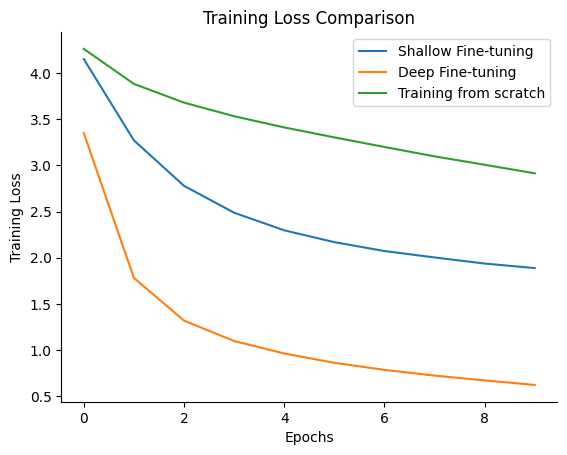

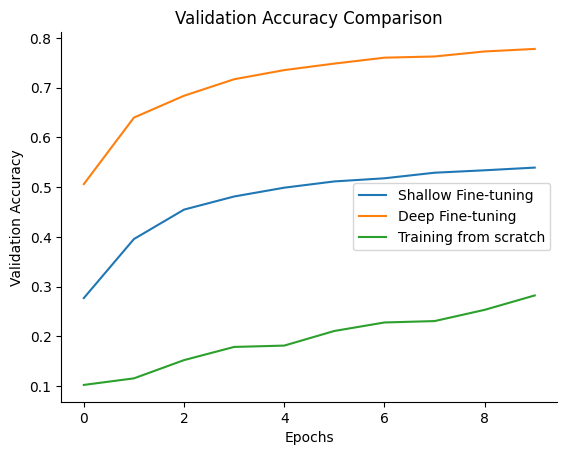

In [13]:
# Comparing the Training loss per epoch
sns.lineplot(x=np.arange(len(shallow_finetuning_train_loss)), y=shallow_finetuning_train_loss, label="Shallow Fine-tuning")
sns.lineplot(x=np.arange(len(deep_finetuning_train_loss)), y=deep_finetuning_train_loss, label="Deep Fine-tuning")
sns.lineplot(x=np.arange(len(scratch_train_loss)), y=scratch_train_loss, label="Training from scratch")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
sns.despine()
plt.title("Training Loss Comparison")
plt.show()
plt.close()

# Comparing the validation accuracies per epoch
sns.lineplot(x=np.arange(len(shallow_finetuning_val_acc)), y=shallow_finetuning_val_acc, label="Shallow Fine-tuning")
sns.lineplot(x=np.arange(len(deep_finetuning_val_acc)), y=deep_finetuning_val_acc, label="Deep Fine-tuning")
sns.lineplot(x=np.arange(len(scratch_val_acc)), y=scratch_val_acc, label="Training from scratch")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
sns.despine()
plt.title("Validation Accuracy Comparison")
plt.show()
plt.close()